# Ames, Iowa Housing Data - Model Fitting and Evaluation

In this notebook, we create our linear regression model and evaluate the performance of the model using a number of metrics. This notebook contains the following sections:
- [Linear Regression Model Fitting](#Linear-Regression-Model-Fitting)
- [Model Evaluation](#Model-Evaluation)
- [Model Iterations](#Model-Iterations)

In [1]:
# Import relevant libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from general_functions import LeeFunctions as lf


In [2]:
%%capture
%store -r datasets

# Retrieve our cleaned and prepped data sets from the EDA notebook. If that notebook has not been run yet in the kernel, this runs that file first then retrieves the data

try:
    datasets
except:
    %run ./p2_eda.ipynb
    %store -r datasets
    
y = datasets[2]
datasets = datasets[:2]

## Linear Regression Model Fitting
Using the cleaned data, we first scale the variables that are numerical. While not strictly necessary for linear regression, it is usually not detrimental and allows the data to be used in other types of models such as Lasso. For our purposes, however, our primary model will be a multi-linear regression (MLS) model with house sale prices as our target variable. In an effort to mitigate heteroscedasticity, we fit our model to the log of sale price

In [3]:
# Split our training data into train/test data sets in order to properly train and evaluate our model. We select here a 70/30 train/test split

xtrain, xtest, ytrain, ytest = train_test_split(datasets[0], y, test_size=0.3, random_state=42)
xtrain, xtest = xtrain.copy(), xtest.copy()

In [4]:
# Scale the features listed below in list [scales] - using the standard scaler, this converts the values in these features to z-scores

scales = ['age','total_bsmt_sf','garage_area', 'gr_liv_area']

ss = StandardScaler()
ss.fit(xtrain[scales])

for frame in [xtrain,xtest,datasets[1]]:
    lf.scale_frame(frame, scales, ss)

In [5]:
# Instantiate and fit our multiple linear regression model. As stated above, we use the log of sale price as our target variable for the fit. Generate predicted values for both training
# and test data sets using the fitted model

lr = LinearRegression()
lr.fit(xtrain, np.log(ytrain))

train_pred = np.exp(lr.predict(xtrain))
test_pred = np.exp(lr.predict(xtest))

# Create a list that compiles relevant objects to pass to the visualization notebook: model data sets, fit scaler, and fit linear regression model
model_pass = [datasets, ss, lr]

## Model Evaluation
We evaluate our model using a number of different metrics, as well as determining if some of the assumptions necessary for linear regression hold true for our data. These metrics are the values by which we determine how effective our model is at predicting sale prices of the test data set. As will be described later, previous iterations of the model generally had lower scores; specifically for the R<sup>2</sup> value and root mean squared error (RMSE)

In [6]:
# Calculate the R^2, RMSE values and the cross value score for our model

train_rmse = int((metrics.mean_squared_error(ytrain, train_pred))**0.5)
test_rmse = int((metrics.mean_squared_error(ytest, test_pred))**0.5)
train_r2 = round(metrics.r2_score(ytrain, train_pred),3)
test_r2 = round(metrics.r2_score(ytest, test_pred),3)

print(f'Training R2: {train_r2}\nTest R2: {test_r2}\nTraining RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}\nCross Validation Score: {round(cross_val_score(lr, xtrain, np.log(ytrain)).mean(),3)}')

Training R2: 0.894
Test R2: 0.914
Training RMSE: 25425
Test RMSE: 23966
Cross Validation Score: 0.858


When considering R<sup>2</sup> values, it is generally important to consider two things: the absolute value of the R<sup>2</sup> and the difference between the training and test R<sup>2</sup>. In looking at these two factors, we are trying to optimize our [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). Bias is minimized when our R<sup>2</sup> values approach 1 (a perfect fit). From our data, our R<sup>2</sup> values are approximately 0.9, which means our model can account for around 90% of the exhibited variance in sale price, which is good. Variance (overfitting) is minimized by when the test and training R<sup>2</sup>s are close to one another, which again, our model displays, as the two scores are within 0.02 of one another. High variance is marked by higher scores for training data in comparison to test data. The cross validation score similarly tests for overfitting, and although the score drops slightly, the model is still fairly accurate (~85%). RMSE is another metric closely related to R<sup>2</sup>, but is useful for depicting the (sort of) average of our error in the same units as the target variable. Our models are, on average, around $25,000 dollars off of the actual sale price (perfect RMSE would be 0).

Visually, we can assess our performance by comparing our predicted prices to the actual prices (blue line is perfect fit), and find that our predictions do cluster around that perfect fit line

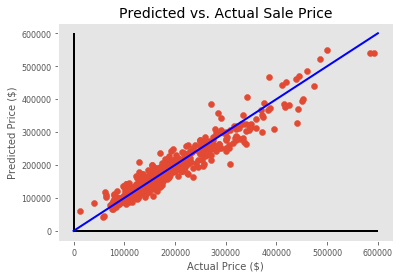

In [7]:
lf.create_scatter(ytest, test_pred, title='Predicted vs. Actual Sale Price', xlabel='Actual Price ($)', ylabel='Predicted Price ($)', fitline=[[0,600000],[0,600000]])

### Assumptions
We can also evaluate how well our model follows some key assumptions necessary for linear regression, sometimes referred to as the [LINE assumptions](https://math.stackexchange.com/questions/1530571/linear-regression-model-assumptions/1533681):
- Linearity: Linear relationship between the dependent variable and each independent variable. We do observe linear relationships when we examine the pairplot we generated previously during our [EDA](p2_eda.ipynb)
- Independent observations: The sale price of one house should not affect the sale price of another house. While the market pricing of houses is likely affected by some greater trends, individual house sales are unlikely to affect the next
- Normal distribution of errors: From the plot (below, left) of the distribution of our residuals, we do observe a fairly normal distribution
- Equal variance (homoscedasticity): From the plot (below, right) of the residuals against the target variable, the residuals are fairly random for low sale prices, although we do observe some spread as sale prices grow larger ('fanning'), so this assumption may be loosely met, or the model is missing some elements

In addition, for multiple linear regression, there is an additional assumption that the independent variables are all independent to one another. During our model preparation, we tried to select variables that were in unique spaces (not having two variables related to garages, for example), so that this assumption would be met

In [8]:
%%capture

lf.create_hist(ytest-test_pred, bins=50, title='Model Residuals', ylabel='counts', xlabel='Residual Value');
lf.create_scatter(ytest, ytest-test_pred, title='Residual vs. Test Value', ylabel='Residual ($)', xlabel='Sale Price ($)');

![](../images/residual_plots.png)

### Regularization
Due to the inclusion of categorical variables that have been dummied out, performing regularization using lasso or ridge regressions is not necessarily optimal. However, it can still provide some insight into how well our model fits. Particularly, we again look at the R<sup>2</sup> values, and alpha levels. Smaller alpha levels indicate that the regularization methods are not drastically shrinking or eliminating coefficients. This is further reinforced by determining which coefficients equal 0 in our lasso fit. All of the removed variables are dummy columns belonging to the neighborhood features, meaning that all of our numerical values are determined to be contributing to the model. The default 5-fold validation was used for both Lasso and Ridge

In [9]:
# Lasso regression model. Print R2, alpha, and zero coefficient variables

lasso = LassoCV()
lasso.fit(xtrain, np.log(ytrain))
print(f'Lasso R2: {round(lasso.score(xtrain, np.log(ytrain)),3)}\nAlpha: {round(lasso.alpha_,6)}')
print({xtrain.columns[x]: lasso.coef_[x] for x in range(len(xtrain.columns)) if lasso.coef_[x] == 0})

Lasso R2: 0.869
Alpha: 0.00029
{'neighborhood_Blueste': 0.0, 'neighborhood_CollgCr': -0.0, 'neighborhood_Greens': 0.0, 'neighborhood_Landmrk': -0.0, 'neighborhood_NPkVill': -0.0, 'neighborhood_SawyerW': -0.0}


In [10]:
# Ridge regression model. Print R2 and alpha

ridge = RidgeCV()
ridge.fit(xtrain, np.log(ytrain))
print(f'Ridge R2: {round(ridge.score(xtrain, np.log(ytrain)),3)}\nAlpha: {round(ridge.alpha_,6)}')

Ridge R2: 0.872
Alpha: 0.1


## Model Iterations
Creating an optimized model is an iterative process, involving selecting model and data parameters, testing the model, and then going back to modify the model based on the previous results. The model described here is the final iteration, but numerous other variables and configurations were tested. We list here a summary of the variable and features tested that were not included in this final version. Initial variable selection did not use as structured approach as was eventually used (and described) to create the final models. Attempted variables were added, found to have minimal change, and then removed

Initial model: Utilities, building type, overall condition, heating qc, central air, grade living area, miscellaneous value
  - R<sup>2</sup>: 0.626
  - RMSE = 49699  

Iteration 2  
- Drop: Miscellaneous value, utilities, central air  
- Add: Age  
- Attempt: Presence of pool (pool size > 0)  
  - R<sup>2</sup>: 0.665
  - RMSE: 46858

Iteration 3
- Add: Neighborhood
- Attempt: Total rooms above grade, garage type
  - R<sup>2</sup>: 0.790
  - RMSE: 37152

Iteration 4
- Add: Overall quality, garage area
- Remove: Overall condition, heating qc
  - R<sup>2</sup>: 0.847
  - RMSE: 31634

Iteration 5
- Modify: Overall quality collapsed to 5 bins
  - R<sup>2</sup>: 0.832
  - RMSE: 32410

Iteration 6
- Add: Polynomial features for all variables
- Increases R<sup>2</sup> but balloons column count to 740 and is very overfitted
  - R<sup>2</sup>: 0.877
  - RMSE: 29464
  - Cross Validation Score: 0.699

Iteration 7 
- Add: Full baths
- Drop: Reduced polynomial features for only discrete or continuous variables
- Attempt: Month sold
- Cross validation score and Kaggle submission score decreased, revert model to iteration 5
  - R<sup>2</sup>: 0.86
  - RMSE: 28863

Iteration 8: Final
- Applied more systematic approach to variable selection
  - R<sup>2</sup>: 0.894
  - RMSE: 25425

## Kaggle Price Predictions

In [11]:
# Create predicted prices for submission and write to csv file

test = pd.read_csv('../datasets/test.csv')
predict = np.exp(lr.predict(datasets[1]))
solution = pd.DataFrame(index=range(878), columns=['Id', 'SalePrice'])
solution['SalePrice'] = predict
solution['Id'] = list(test['Id'])
solution.set_index('Id', inplace=True, drop=False)
solution.sort_index(inplace=True)
solution.to_csv('../datasets/p2_lee_predict.csv', index = False)

In [12]:
%%capture
%store model_pass

# Store our cleaned and prepped data sets to pass to our modeling notebook